<a href="https://colab.research.google.com/github/Sudeepam97/IMDb-rating-prediction/blob/master/classifier.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from google.colab import drive
drive.mount('/content/drive')

# Creating a Dataset

In [0]:
%cd drive/My\ Drive/Projects/movie_classification

/content/drive/My Drive/Projects/movie_classification


In [0]:
import requests
import time
from bs4 import BeautifulSoup
import pandas as pd

In [0]:
def find_director_and_cast_names(soup):
  '''this function handles the scraping of cast and 
  director names which is slightly more tricky'''
  director_and_cast = []
  for mv in soup.find_all('p'):
    content = mv.text[5:]
    if content.startswith("Director"):
      names = content.replace('\n', '').replace('    ', '/').replace('|', '')
      director_and_cast.append(names)
  return(director_and_cast)

def scrape_data(soup):
  '''returns the movie name, director of movie, cast,
  runtime, rating, and genre of the movie. Synopsis later'''
  movie_name = [mv.get('alt') for mv in soup.find_all('img')]
  movie_name = movie_name[2:]

  director_and_cast = find_director_and_cast_names(soup)
  director_name = [mv[mv.find(':') + 1 : mv.find('/')] for mv in director_and_cast]
  cast_names = [mv[mv.find('Stars:') + 6:] for mv in director_and_cast]

  movie_runtime = [run_t.string.replace(' min', '') for run_t in soup.find_all('span', class_="runtime")]
  movie_rating = [rat.string for rat in soup.find_all('span', class_="value")]
  movie_genre = [gr.string[1:].rstrip() for gr in soup.find_all('span', class_="genre")]

  return movie_name, director_name, cast_names, movie_runtime, movie_rating, movie_genre

***Note***: **`response.text`** shows the HTML whereas **`response.content`** shows the raw bytes. `lxml` is our parsing engine.
 

In [0]:
movie = []
director = []
cast = []
runtime = []
rating = []
genre = []

def get_features():
  base_url_1 = 'https://www.imdb.com/search/title/?title_type=feature&year=1985-01-01,2019-12-31&sort=num_votes,desc&start='
  base_url_2 = '&ref_=adv_nxt'
  for i in range(1, 10000, 50):
    time.sleep(1) # be nice to the servers :)
    url = base_url_1 + str(i) + base_url_2
    response = requests.get(url)
    soup = BeautifulSoup(response.text, 'lxml')
    movie_name, director_name, cast_names, movie_runtime, movie_rating, movie_genre = scrape_data(soup)

    movie.extend(movie_name)
    director.extend(director_name)
    cast.extend(cast_names)
    runtime.extend(movie_runtime)
    rating.extend(movie_rating)
    genre.extend(movie_genre)
    print("Set " + str(int((i-1) / 50) + 1) + " done...")

get_features()
# Handle an exception
del director[6198]
del cast[6198]
print("All Done!")

In [0]:
# Sanity Check the shapes of scraped data
print(f"movie: {len(movie)}")
print(f"director: {len(director)}")
print(f"cast: {len(cast)}")
print(f"genre: {len(genre)}")
print(f"runtime: {len(runtime)}")
print(f"rating: {len(rating)}")

In [0]:
output = pd.DataFrame({'movie': movie,
                       'director': director,
                       'genre': genre,
                       'runtime': runtime,
                       'cast': cast,
                       'rating': rating})
output.to_csv('data.csv', index=False)

In [0]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


# Feature Engineering

In [0]:
%cd drive/My\ Drive/Projects/movie_classification

In [0]:
import pandas as pd
import numpy as np

In [0]:
data = pd.read_csv('data.csv')
data.head()

,movie,director,genre,runtime,cast,rating
0,The Shawshank Redemption,Frank Darabont,Drama,142,"Tim Robbins, Morgan Freeman, Bob Gunton, Willi...",9.3
1,The Dark Knight,Christopher Nolan,"Action, Crime, Drama",152,"Christian Bale, Heath Ledger, Aaron Eckhart, M...",9.0
2,Inception,Christopher Nolan,"Action, Adventure, Sci-Fi",148,"Leonardo DiCaprio, Joseph Gordon-Levitt, Ellen...",8.8
3,Fight Club,David Fincher,Drama,139,"Brad Pitt, Edward Norton, Meat Loaf, Zach Grenier",8.8
4,Pulp Fiction,Quentin Tarantino,"Crime, Drama",154,"John Travolta, Uma Thurman, Samuel L. Jackson,...",8.9


In [0]:
def split_column_values(column):
  column_vals = data.loc[:, column]
  df = pd.DataFrame([curr_movie.split(", ") for curr_movie in column_vals])

  if column == 'director':
    df.drop(range(2, len(df.columns)), axis = 1, inplace = True) # keep the 2 major directors
    df.columns = ["director_0", "director_1"]
    df.director_1.fillna(df.director_0, inplace = True)
  elif column == 'cast':
    df.columns = ["lead_" + str(i) for i in range(0, len(df.columns))]
  elif column == 'genre':
    df = pd.get_dummies(df, prefix_sep='', prefix='').max(level=0, axis=1)   

  return df

In [0]:
# Call
directors = split_column_values('director')
cast_members = split_column_values('cast')
genres = split_column_values('genre')
data.drop(['director', 'cast', 'genre'], axis = 1, inplace = True)
data = pd.concat([directors, cast_members, genres, data], axis=1)
data.head()

,director_0,director_1,lead_0,lead_1,lead_2,lead_3,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Thriller,War,History,Sport,Western,movie,runtime,rating
0,Frank Darabont,Frank Darabont,Tim Robbins,Morgan Freeman,Bob Gunton,William Sadler,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The Shawshank Redemption,142,9.3
1,Christopher Nolan,Christopher Nolan,Christian Bale,Heath Ledger,Aaron Eckhart,Michael Caine,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The Dark Knight,152,9.0
2,Christopher Nolan,Christopher Nolan,Leonardo DiCaprio,Joseph Gordon-Levitt,Ellen Page,Ken Watanabe,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Inception,148,8.8
3,David Fincher,David Fincher,Brad Pitt,Edward Norton,Meat Loaf,Zach Grenier,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Fight Club,139,8.8
4,Quentin Tarantino,Quentin Tarantino,John Travolta,Uma Thurman,Samuel L. Jackson,Bruce Willis,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Pulp Fiction,154,8.9


In [0]:
# Check for columns with missing values
print(data.columns[data.isnull().any()])

Index(['lead_1', 'lead_2', 'lead_3'], dtype='object')


In [0]:
# Drop the rows with columns having missing values
data = data[pd.notnull(data['lead_1'])]
data = data[pd.notnull(data['lead_2'])]
data = data[pd.notnull(data['lead_3'])]
print(len(data)) # Dropping was fine because only a few data points were lost 

9979


In [0]:
def scores_from_each_movie(contributors):
  '''returns a dataframe that contains the contribution of
  each movie to the score of its cast or director.
  Input:
  -----
  Assuming average rating = x, and input is:

            | lead_0 | lead_1 | lead_2 | lead_3 | rating
              ------   ------   ------   ------   ------
  movie_xyz |    A   |    B   |    C   |   D    |   9
  
  output: Scores for A, B, C and D respectively
  ------
            | lead_0   |  lead_1  |  lead_2  |  lead_3
              ------   |  ------  |  ------  |  ------
  movie_xyz |  6*(9-x) |  5*(9-x) |  4*(9-x) |  3*(9-x)   
  '''
  normalized_ratings = data['rating'].sub(data['rating'].mean(), axis = 0)
  if contributors == 'cast':
    scores = [normalized_ratings * i for i in [6, 5, 4, 3]] # [6, 5, 4, 3] are scores per member according to contribution
  elif contributors == 'director':
    scores = [normalized_ratings * i for i in [5, 5]]

  scores = np.array(scores).transpose()
  return pd.DataFrame(scores)

def get_contributors_rating(contributors):
  '''Returns a numerical rating for each director
  and actor in the form of a dictonary'''
  score_df = scores_from_each_movie(contributors)
  if contributors == 'cast':
    df_temp = data[['lead_0', 'lead_1', 'lead_2', 'lead_3']]
  elif contributors == 'director':
    df_temp = data[['director_0', 'director_1']]
  contributors_ratings = score_df.stack().groupby(df_temp.stack().values).mean().to_dict()
  return contributors_ratings

In [0]:
# Call
actor_ratings = get_contributors_rating('cast')
director_ratings = get_contributors_rating('director')
print(actor_ratings)
print(director_ratings)

{"'Weird Al' Yankovic": 3.3207736246119097, '50 Cent': -4.819392152090643, 'A. Michael Baldwin': -3.1059575107724164, 'A.C. Peterson': -2.539613187694046, 'A.J. Cook': -1.7815345559005238, 'A.J. Langer': -0.13961318769404407, 'A.R. Murugadoss': 3.2673113538432563, 'AJ Bowen': -1.6349968266691774, 'AJ Michalka': 2.767311353843258, 'Aadhi': 8.213849083074606, 'Aadukalam Naren': 6.2138490830746065, 'Aahana Kumra': 0.4440424892275838, 'Aaliyah': -4.3059575107724175, 'Aamir Khan': 5.51566569796594, 'Aanchal Munjal': -0.13961318769404407, 'Aaran Thomas': -0.7396131876940446, 'Aarav Khanna': 6.32077362461191, 'Aaron Abrams': 0.7673113538432581, 'Aaron Ashmore': -5.079226375388092, 'Aaron Benjamin': -4.186150916925392, 'Aaron Burns': -4.612882052309719, 'Aaron Davis': -7.73268864615674, 'Aaron Dismuke': 5.267311353843258, 'Aaron Douglas': -4.186150916925392, 'Aaron Eckhart': 0.07772470335873462, 'Aaron Glenane': -1.9396131876940457, 'Aaron Jeffery': 3.013849083074607, 'Aaron Moorhead': 0.32077

In [0]:
def replace_with_scores(contributors):
  df_temp = None
  if contributors == 'cast':
    df_temp = pd.DataFrame(data['lead_0'].map(actor_ratings))
    for lead in ['lead_1', 'lead_2', 'lead_3']:
      df = pd.DataFrame(data[lead].map(actor_ratings))
      df_temp = pd.concat([df_temp, df], axis=1)
  elif contributors == 'director':
    df_temp = pd.DataFrame(data['director_0'].map(director_ratings))
    df = pd.DataFrame(data['director_1'].map(director_ratings))
    df_temp = pd.concat([df_temp, df], axis=1)
  return df_temp

In [0]:
df_1 = replace_with_scores('cast')
df_2 = replace_with_scores('director')
data.drop(['director_0', 'director_1', 'lead_0', 'lead_1', 'lead_2', 'lead_3'], axis = 1, inplace = True)
data = pd.concat([df_1, df_2, data], axis=1)
data.head()

,lead_0,lead_1,lead_2,lead_3,director_0,director_1,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Thriller,War,History,Sport,Western,movie,runtime,rating
0,1.543622,0.750132,-0.667536,0.450058,7.767311,7.767311,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The Shawshank Redemption,142,9.3
1,3.784812,2.532260,0.077725,2.069438,9.067311,9.067311,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The Dark Knight,152,9.0
2,5.861750,2.766140,0.748994,4.576114,9.067311,9.067311,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Inception,148,8.8
3,3.975257,3.271659,1.196028,2.260387,6.517311,6.517311,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Fight Club,139,8.8
4,-2.394897,-1.611668,-0.533383,-1.313259,8.167311,8.167311,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Pulp Fiction,154,8.9


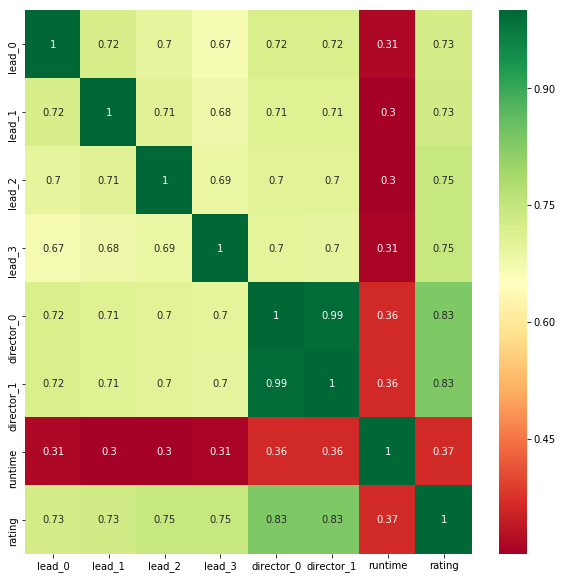

In [0]:
import matplotlib.pyplot as plt
import seaborn as sns
engineered = data[['lead_0', 'lead_1', 'lead_2', 'lead_3', 'director_0', 'director_1', 'runtime', 'rating']]
corrmat = engineered.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(10, 10))
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [0]:
# cast and directors have been well correlated
# with ratings so we can save this data now.
data.to_csv('processed_data.csv', index=False)

# Model Building

In [1]:
%reset
%cd drive/My\ Drive/Projects/movie_classification

Once deleted, variables cannot be recovered. Proceed (y/[n])? y
/content/drive/My Drive/Projects/movie_classification


In [0]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split

In [3]:
data = pd.read_csv('processed_data.csv')
data.head()

,lead_0,lead_1,lead_2,lead_3,director_0,director_1,Action,Adventure,Animation,Biography,Comedy,Crime,Drama,Family,Fantasy,Horror,Music,Musical,Mystery,Romance,Sci-Fi,Thriller,War,History,Sport,Western,movie,runtime,rating
0,1.543622,0.750132,-0.667536,0.450058,7.767311,7.767311,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The Shawshank Redemption,142,9.3
1,3.784812,2.532260,0.077725,2.069438,9.067311,9.067311,1,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,The Dark Knight,152,9.0
2,5.861750,2.766140,0.748994,4.576114,9.067311,9.067311,1,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,Inception,148,8.8
3,3.975257,3.271659,1.196028,2.260387,6.517311,6.517311,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Fight Club,139,8.8
4,-2.394897,-1.611668,-0.533383,-1.313259,8.167311,8.167311,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,Pulp Fiction,154,8.9


In [0]:
# Split dataset.
y = data['rating']
X = data.drop(['rating', 'movie'], axis = 1)

train_X, val_X, train_y, val_y = train_test_split(X, y, random_state = 9, \
                                                  train_size = 0.85, \
                                                  test_size = 0.15)

In [5]:
# Deep Neural Network
def define_architecture():
  model = Sequential()
  model.add(Dense(50, input_dim=27, activation='relu'))
  model.add(Dense(25, activation='relu'))
  model.add(Dense(12, activation='relu'))
  model.add(Dense(1))
  return model

nn_model = define_architecture()
nn_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 50)                1400      
_________________________________________________________________
dense_1 (Dense)              (None, 25)                1275      
_________________________________________________________________
dense_2 (Dense)              (None, 12)                312       
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 13        
Total params: 3,000
Trainable params: 3,000
Non-trainable params: 0
_________________________________________________________________


In [6]:
nn_model.compile(loss='mean_squared_error', optimizer=Adam(lr=0.01))
history = nn_model.fit(x=train_X.values, y=train_y.values, batch_size=64, epochs = 50)

Train on 8482 samples
Epoch 1/50
8482/8482 [==============================] - 1s 92us/sample - loss: 4.2670
Epoch 2/50
8482/8482 [==============================] - 0s 26us/sample - loss: 1.0194
Epoch 3/50
8482/8482 [==============================] - 0s 25us/sample - loss: 0.7730
Epoch 4/50
8482/8482 [==============================] - 0s 27us/sample - loss: 0.5498
Epoch 5/50
8482/8482 [==============================] - 0s 28us/sample - loss: 0.5405
Epoch 6/50
8482/8482 [==============================] - 0s 24us/sample - loss: 0.4111
Epoch 7/50
8482/8482 [==============================] - 0s 25us/sample - loss: 0.3655
Epoch 8/50
8482/8482 [==============================] - 0s 25us/sample - loss: 0.3702
Epoch 9/50
8482/8482 [==============================] - 0s 24us/sample - loss: 0.3180
Epoch 10/50
8482/8482 [==============================] - 0s 26us/sample - loss: 0.2929
Epoch 11/50
8482/8482 [==============================] - 0s 25us/sample - loss: 0.2739
Epoch 12/50
8482/8482 [=======

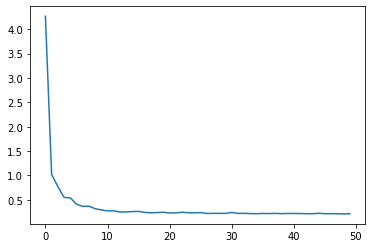

In [7]:
plt.plot(history.history['loss'])

In [8]:
preds = nn_model.evaluate(x=val_X.values, y=val_y.values)
print(preds)

1497/1 [================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================================

In [0]:
nn_model.save('my_model.h5')

# Using the model we created

In [10]:
%reset

Once deleted, variables cannot be recovered. Proceed (y/[n])? y


In [0]:
from tensorflow.keras.models import load_model
import pandas as pd
import numpy as np

data = pd.read_csv('processed_data.csv')
data.head()

nn_model = load_model('my_model.h5')

In [20]:
check = data.iloc[[15]]
name = check.movie.values[0]
check = check.drop(['rating', 'movie'], axis = 1)
pred = float(nn_model.predict(check.values)[0])
pred = round(pred, 2)
print(name)
print(f"predicted rating: {pred}")
print(f"original rating: {data.rating.values[data['movie'] == name][0]}")

Batman Begins
predicted rating: 8.0
original rating: 8.2
